In [33]:
import polars as pl
from transformers import BertTokenizer, BertModel
import torch
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained("bert-base-uncased")

c:\Users\Lauritz\AppData\Local\Programs\Python\Python310\lib\site-packages\huggingface_hub\file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you

In [34]:
# Check if GPU is available and move the model to GPU if it is
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(f"Using device: {device}")

Using device: cpu


In [35]:
def get_mean_bert_embedding(texts):
    encoded_input = tokenizer(texts, padding=True, truncation=True, return_tensors='pt')
    # Move input tensors to the same device as the model
    encoded_input = {k: v.to(device) for k, v in encoded_input.items()}
    
    # Use no_grad to prevent gradient computation and save memory
    with torch.no_grad():
        output = model(**encoded_input)
        sentence_embedding = output.last_hidden_state.mean(dim=1)
    
    # Move back to CPU for numpy conversion and clear GPU cache
    result = sentence_embedding.cpu().detach().numpy()
    torch.cuda.empty_cache()
    return result

In [36]:
df = pl.scan_csv('../../data/clean/rotten_tomatoes_movie_details_clean.csv')

In [37]:
df.collect().shape

(17661, 4)

In [93]:
def embed_batch(df: pl.DataFrame) -> pl.DataFrame:
    # Ensure pure Python strings
    texts = [str(x) for x in df["description"].to_list()]
    
    # Process in smaller chunks to avoid OOM
    chunk_size = 32  # Adjust this based on your GPU memory
    embeddings = []
    
    for i in range(0, len(texts), chunk_size):
        chunk = texts[i:i+chunk_size]
        emb = get_mean_bert_embedding(chunk)
        embeddings.append(emb)
    
    # Concatenate all embeddings
    import numpy as np
    all_embeddings = np.vstack(embeddings)

    
    return pl.DataFrame({"embedding": all_embeddings}, schema={"embedding": pl.Array(pl.Float64, shape=768)})

In [96]:
import numpy as np

out = df.head(10).map_batches(embed_batch, schema={"embedding": pl.Array(pl.Float64, shape=768)})
data = out.collect().to_numpy()
data = np.stack(data.squeeze(1))

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(data)

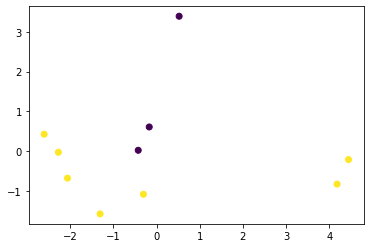

In [97]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
data_2d = pca.fit_transform(data)

plt.scatter(data_2d[:, 0], data_2d[:, 1], c=kmeans.labels_)